### Импорт библиотек

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandahouse as ph
import scipy.stats as stats

In [2]:
plt.rcParams['figure.figsize'] = [22, 11]

### Напишем запрос к бд и посмотрим на данные

In [3]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database':'simulator_20230320',
    'user':'student', 
    'password':'dpo_python_2020'
}

query = '''
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-02-23' and '2023-03-01'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
'''

In [4]:
df = ph.read_clickhouse(query, connection=connection)

In [5]:
df.head(10)

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667
5,2,24239,53,119,0.445378
6,3,19647,21,146,0.143836
7,2,14680,8,70,0.114286
8,2,127588,7,44,0.159091
9,2,119153,14,61,0.229508


In [6]:
df.groupby('exp_group').ctr.count().reset_index()

,exp_group,ctr
0,2,8480
1,3,8569


### Построим гистограмму распределения CTR двух групп

<AxesSubplot:xlabel='ctr', ylabel='Count'>

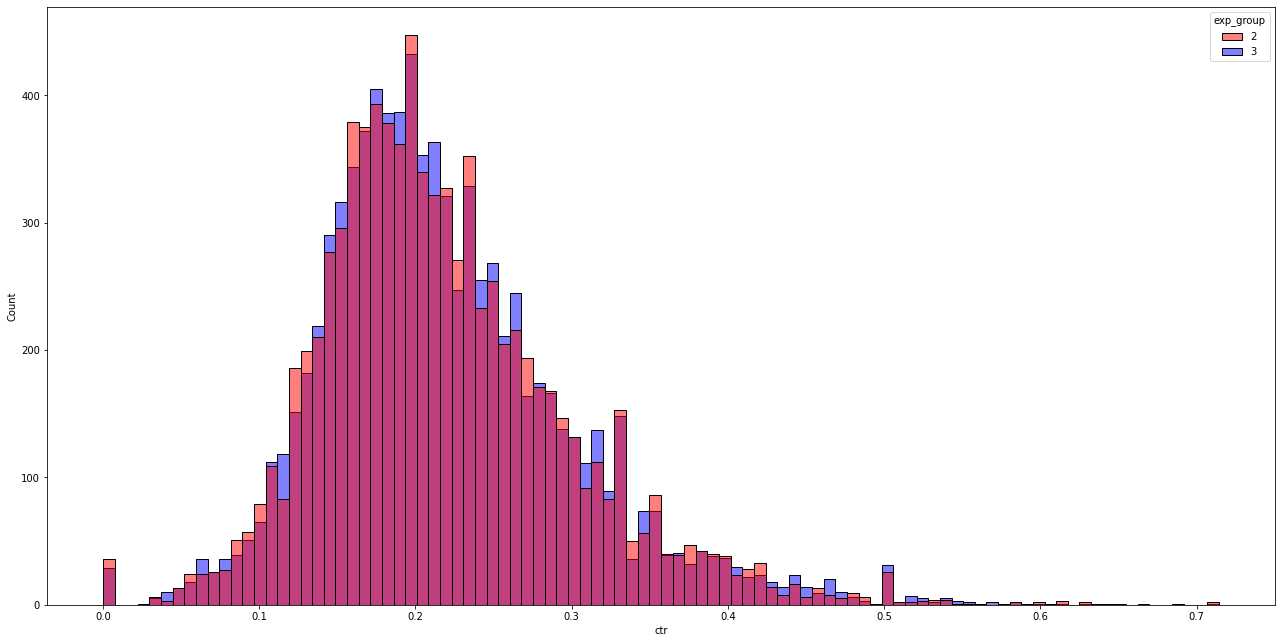

In [7]:
sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

### Видимых различий между группами нет
### Проверим, есть ли различия, проведя Т-тест и тест Манна-Уитни

In [8]:
stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-0.7393597924958364, pvalue=0.45969873156476293)

In [9]:
stats.mannwhitneyu(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr)

MannwhitneyuResult(statistic=36124728.5, pvalue=0.5177480614337441)

### Получившиеся p-value высокое, можем полагать что различий нет

### Проведем т-тест среди 500 значений 10000 раз и посмотрим на гистограмму получившихся p-value

In [10]:
p_values = []
for _ in range(10000):
    p_values.append(stats.ttest_ind(df[df.exp_group == 2].ctr.sample(500, replace=False).values, df[df.exp_group == 3].ctr.sample(500, replace=False).values)[1])

<AxesSubplot:ylabel='Count'>

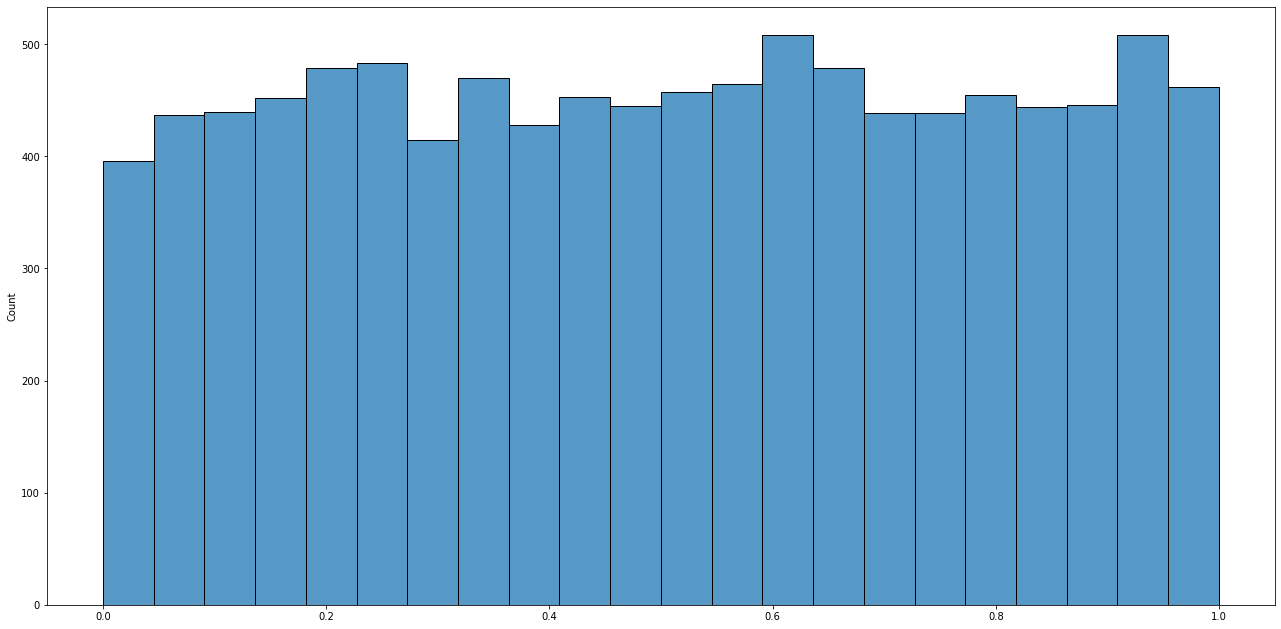

In [11]:
sns.histplot(data = p_values, kde=False)

### Посчитаем % p-value <= 0.05

In [12]:
sum(np.array(p_values) <= 0.05) / 10000

0.0444

# На основе гистограммы и % p-value менее 0.05 можно сделать вывод что наша система сплитования работает корректно